In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import collections
import networkx as nx
from Bio.Seq import Seq
from Bio import SeqIO

## LOOK AT AMINO ACID VARIaATIONS

In [28]:
c4Aensembl = pd.read_csv("/home/mark/Desktop/HLA/C4/ensembl_C4A_proteinVariants.csv")
c4AensemblDF = c4Aensembl[c4Aensembl['Conseq. Type']!='synonymous variant'].copy()
#c4AensemblDF = c4Aensembl.copy()


c4Bensembl = pd.read_csv("/home/mark/Desktop/HLA/C4/ensembl_C4B_proteinVariants.csv")
c4BensemblDF = c4Bensembl[c4Bensembl['Conseq. Type']!='synonymous variant'].copy()
#c4BensemblDF = c4Bensembl.copy()

In [29]:
AllC4ResidueVariants = {y:{'C4A':[], 'C4B':[]} for y in set([x for x in set(c4AensemblDF['Residue'])]+[x for x in set(c4BensemblDF['Residue'])])}

In [30]:
for row in c4AensemblDF.index:
    for residue in str(c4AensemblDF.at[row,'Residues']).split(","):
        if str(residue).strip() in AllC4ResidueVariants[c4AensemblDF.at[row,'Residue']]['C4A']:
            continue
        else:
            AllC4ResidueVariants[c4AensemblDF.at[row,'Residue']]['C4A'].append(str(residue).strip())
            
for row in c4BensemblDF.index:
    for residue in str(c4BensemblDF.at[row,'Residues']).split(","):
        if str(residue).strip() in AllC4ResidueVariants[c4BensemblDF.at[row,'Residue']]['C4B']:
            continue
        else:
            AllC4ResidueVariants[c4BensemblDF.at[row,'Residue']]['C4B'].append(str(residue).strip())

In [31]:
AllC4ResidueVariants

{5: {'C4A': [], 'C4B': ['WG', 'WX']},
 84: {'C4A': ['L', 'F'], 'C4B': ['L', 'F']},
 138: {'C4A': ['R', 'Q'], 'C4B': ['R', 'Q']},
 141: {'C4A': ['L', 'V'], 'C4B': ['L', 'V']},
 193: {'C4A': [], 'C4B': ['M', 'T']},
 211: {'C4A': ['G', 'E'], 'C4B': []},
 290: {'C4A': ['D', 'G'], 'C4B': []},
 347: {'C4A': ['Y', 'S', 'C', 'F'], 'C4B': ['S', 'Y']},
 360: {'C4A': ['W', '*'], 'C4B': []},
 477: {'C4A': ['W', 'R'], 'C4B': ['R', 'W']},
 482: {'C4A': ['P', 'R'], 'C4B': ['P', 'R']},
 527: {'C4A': ['T', 'A'], 'C4B': ['T', 'A']},
 549: {'C4A': ['H', 'P'], 'C4B': ['H', 'P']},
 608: {'C4A': [], 'C4B': ['L', 'V']},
 714: {'C4A': ['R', 'S'], 'C4B': ['R', 'S']},
 726: {'C4A': ['P', 'L'], 'C4B': []},
 729: {'C4A': ['R', 'Q'], 'C4B': []},
 752: {'C4A': [], 'C4B': ['A', 'V']},
 764: {'C4A': [], 'C4B': ['E', 'D']},
 775: {'C4A': [], 'C4B': ['R', 'C']},
 790: {'C4A': [], 'C4B': ['D', 'N']},
 791: {'C4A': ['R', 'H'], 'C4B': ['R', 'H']},
 794: {'C4A': [], 'C4B': ['I', 'T']},
 798: {'C4A': [], 'C4B': ['W', 'R']},

## Load in Data

In [32]:
newC4DF = pd.read_csv("/home/mark/Desktop/HLA/HengLi/C4_Combined_MINE_Heng.csv").drop(columns=['Unnamed: 0'])
newC4DF.head(2)

,Grouping,Gene,Orientation,Exon,Divergence,INS,DEL,Length,DistanceFromLastExon,Sample_Haplotype,Start,End,NewStart,NewEnd,HengAnnotation
0,FullGroup,C4B_1,+,C4B-202_EXON_1,0.0,0.0,0.0,1.0,471041,HG02818.hap1,3935403,3935518,1000,1115,C4AL
1,FullGroup,C4B_1,+,C4B-202_EXON_2,0.0,0.0,0.0,1.0,133,HG02818.hap1,3935651,3935849,1248,1446,C4AL


In [33]:
ReferenceDataBase= {'C4A-243':'MRLLWGLIWASSFFTLSLQKPRLLLFSPSVVHLGVPLSVGVQLQDVPRGQVVKGSVFLRNPSRNNVPCSPKVDFTLSSERDFALLSLQVPLKDAKSCGLHQLLRGPEVQLVAHSPWLKDSLSRTTNIQGINLLFSSRRGHLFLQTDQPIYNPGQRVRYRVFALDQKMRPSTDTITVMVENSHGLRVRKKEVYMPSSIFQDDFVIPDISEPGTWKISARFSDGLESNSSTQFEVKKYVLPNFEVKITPGKPYILTVPGHLDEMQLDIQARYIYGKPVQGVAYVRFGLLDEDGKKTFFRGLESQTKLVNGQSHISLSKAEFQDALEKLNMGITDLQGLRLYVAAAIIESPGGEMEEAELTSWYFVSSPFSLDLSKTKRHLVPGAPFLLQALVREMSGSPASGIPVKVSATVSSPGSVPEVQDIQQNTDGSGQVSIPIIIPQTISELQLSVSAGSPHPAIARLTVAAPPSGGPGFLSIERPDSRPPRVGDTLNLNLRAVGSGATFSHYYYMILSRGQIVFMNREPKRTLTSVSVFVDHHLAPSFYFVAFYYHGDHPVANSLRVDVQAGACEGKLELSVDGAKQYRNGESVKLHLETDSLALVALGALDTALYAAGSKSHKPLNMGKVFEAMNSYDLGCGPGGGDSALQVFQAAGLAFSDGDQWTLSRKRLSCPKEKTTRKKRNVNFQKAINEKLGQYASPTAKRCCQDGVTRLPMMRSCEQRAARVQQPDCREPFLSCCQFAESLRKKSRDKGQAGLQRALEILQEEDLIDEDDIPVRSFFPENWLWRVETVDRFQILTLWLPDSLTTWEIHGLSLSKTKGLCVATPVQLRVFREFHLHLRLPMSVRRFEQLELRPVLYNYLDKNLTVSVHVSPVEGLCLAGGGGLAQQVLVPAGSARPVAFSVVPTAAAAVSLKVVARGSFEFPVGDAVSKVLQIEKEGAIHREELVYELNPLDHRGRTLEIPGNSDPNMIPDGDFNSYVRVTASDPLDTLGSEGALSPGGVASLLRLPRGCGEQTMIYLAPTLAASRYLDKTEQWSTLPPETKDHAVDLIQKGYMRIQQFRKADGSYAAWLSRDSSTWLTAFVLKVLSLAQEQVGGSPEKLQETSNWLLSQQQADGSFQDPCPVLDRSMQGGLVGNDETVALTAFVTIALHHGLAVFQDEGAEPLKQRVEASISKANSFLGEKASAGLLGAHAAAITAYALTLTKAPVDLLGVAHNNLMAMAQETGDNLYWGSVTGSQSNAVSPTPAPRNPSDPMPQAPALWIETTAYALLHLLLHEGKAEMADQASAWLTRQGSFQGGFRSTQDTVIALDALSAYWIASHTTEERGLNVTLSSTGRNGFKSHALQLNNRQIRGLEEELQFSLGSKINVKVGGNSKGTLKVLRTYNVLDMKNTTCQDLQIEVTVKGHVEYTMEANEDYEDYEYDELPAKDDPDAPLQPVTPLQLFEGRRNRRRREAPKVVEEQESRVHYTVCIWRNGKVGLSGMAIADVTLLSGFHALRADLEKLTSLSDRYVSHFETEGPHVLLYFDSVPTSRECVGFEAVQEVPVGLVQPASATLYDYYNPERRCSVFYGAPSKSRLLATLCSAEVCQCAEGKCPRQRRALERGLQDEDGYRMKFACYYPRVEYGFQVKVLREDSRAAFRLFETKITQVLHFTKDVKAAANQMRNFLVRASCRLRLEPGKEYLIMGLDGATYDLEGHPQYLLDSNSWIEEMPSERLCRSTRQRAACAQLNDFLQEYGTQGCQV', 
                    'C4B-202':'MRLLWGLIWASSFFTLSLQKPRLLLFSPSVVHLGVPLSVGVQLQDVPRGQVVKGSVFLRNPSRNNVPCSPKVDFTLSSERDFALLSLQVPLKDAKSCGLHQLLRGPEVQLVAHSPWLKDSLSRTTNIQGINLLFSSRRGHLFLQTDQPIYNPGQRVRYRVFALDQKMRPSTDTITVMVENSHGLRVRKKEVYMPSSIFQDDFVIPDISEPGTWKISARFSDGLESNSSTQFEVKKYVLPNFEVKITPGKPYILTVPGHLDEMQLDIQARYIYGKPVQGVAYVRFGLLDEDGKKTFFRGLESQTKLVNGQSHISLSKAEFQDALEKLNMGITDLQGLRLYVAAAIIESPGGEMEEAELTSWYFVSSPFSLDLSKTKRHLVPGAPFLLQALVREMSGSPASGIPVKVSATVSSPGSVPEVQDIQQNTDGSGQVSIPIIIPQTISELQLSVSAGSPHPAIARLTVAAPPSGGPGFLSIERPDSRPPRVGDTLNLNLRAVGSGATFSHYYYMILSRGQIVFMNREPKRTLTSVSVFVDHHLAPSFYFVAFYYHGDHPVANSLRVDVQAGACEGKLELSVDGAKQYRNGESVKLHLETDSLALVALGALDTALYAAGSKSHKPLNMGKVFEAMNSYDLGCGPGGGDSALQVFQAAGLAFSDGDQWTLSRKRLSCPKEKTTRKKRNVNFQKAINEKLGQYASPTAKRCCQDGVTRLPMMRSCEQRAARVQQPDCREPFLSCCQFAESLRKKSRDKGQAGLQRALEILQEEDLIDEDDIPVRSFFPENWLWRVETVDRFQILTLWLPDSLTTWEIHGLSLSKTKGLCVATPVQLRVFREFHLHLRLPMSVRRFEQLELRPVLYNYLDKNLTVSVHVSPVEGLCLAGGGGLAQQVLVPAGSARPVAFSVVPTAATAVSLKVVARGSFEFPVGDAVSKVLQIEKEGAIHREELVYELNPLDHRGRTLEIPGNSDPNMIPDGDFNSYVRVTASDPLDTLGSEGALSPGGVASLLRLPRGCGEQTMIYLAPTLAASRYLDKTEQWSTLPPETKDHAVDLIQKGYMRIQQFRKADGSYAAWLSRGSSTWLTAFVLKVLSLAQEQVGGSPEKLQETSNWLLSQQQADGSFQDLSPVIHRSMQGGLVGNDETVALTAFVTIALHHGLAVFQDEGAEPLKQRVEASISKASSFLGEKASAGLLGAHAAAITAYALTLTKAPADLRGVAHNNLMAMAQETGDNLYWGSVTGSQSNAVSPTPAPRNPSDPMPQAPALWIETTAYALLHLLLHEGKAEMADQAAAWLTRQGSFQGGFRSTQDTVIALDALSAYWIASHTTEERGLNVTLSSTGRNGFKSHALQLNNRQIRGLEEELQFSLGSKINVKVGGNSKGTLKVLRTYNVLDMKNTTCQDLQIEVTVKGHVEYTMEANEDYEDYEYDELPAKDDPDAPLQPVTPLQLFEGRRNRRRREAPKVVEEQESRVHYTVCIWRNGKVGLSGMAIADVTLLSGFHALRADLEKLTSLSDRYVSHFETEGPHVLLYFDSVPTSRECVGFEAVQEVPVGLVQPASATLYDYYNPERRCSVFYGAPSKSRLLATLCSAEVCQCAEGKCPRQRRALERGLQDEDGYRMKFACYYPRVEYGFQVKVLREDSRAAFRLFETKITQVLHFTKDVKAAANQMRNFLVRASCRLRLEPGKEYLIMGLDGATYDLEGHPQYLLDSNSWIEEMPSERLCRSTRQRAACAQLNDFLQEYGTQGCQV'} 
newRefDict={}
for item in ReferenceDataBase.keys():
    newRefDict[item]=[x for x in ReferenceDataBase[item]]
newRefAminoDF = pd.DataFrame.from_dict(newRefDict).T
newRefAminoDF.columns+=1
keepRefColumns=[]
for column in newRefAminoDF.columns:
    if len(set(newRefAminoDF[column]))==1:
        continue
    else:
        keepRefColumns.append(column)

In [34]:
referenceVariantsDictionary ={}
for column in newRefAminoDF.columns:
    referenceVariantsDictionary[column]=[]
    for x in set(newRefAminoDF[column]):
        referenceVariantsDictionary[column].append(x)

In [35]:
referenceVariantsDictionary

{1: ['M'],
 2: ['R'],
 3: ['L'],
 4: ['L'],
 5: ['W'],
 6: ['G'],
 7: ['L'],
 8: ['I'],
 9: ['W'],
 10: ['A'],
 11: ['S'],
 12: ['S'],
 13: ['F'],
 14: ['F'],
 15: ['T'],
 16: ['L'],
 17: ['S'],
 18: ['L'],
 19: ['Q'],
 20: ['K'],
 21: ['P'],
 22: ['R'],
 23: ['L'],
 24: ['L'],
 25: ['L'],
 26: ['F'],
 27: ['S'],
 28: ['P'],
 29: ['S'],
 30: ['V'],
 31: ['V'],
 32: ['H'],
 33: ['L'],
 34: ['G'],
 35: ['V'],
 36: ['P'],
 37: ['L'],
 38: ['S'],
 39: ['V'],
 40: ['G'],
 41: ['V'],
 42: ['Q'],
 43: ['L'],
 44: ['Q'],
 45: ['D'],
 46: ['V'],
 47: ['P'],
 48: ['R'],
 49: ['G'],
 50: ['Q'],
 51: ['V'],
 52: ['V'],
 53: ['K'],
 54: ['G'],
 55: ['S'],
 56: ['V'],
 57: ['F'],
 58: ['L'],
 59: ['R'],
 60: ['N'],
 61: ['P'],
 62: ['S'],
 63: ['R'],
 64: ['N'],
 65: ['N'],
 66: ['V'],
 67: ['P'],
 68: ['C'],
 69: ['S'],
 70: ['P'],
 71: ['K'],
 72: ['V'],
 73: ['D'],
 74: ['F'],
 75: ['T'],
 76: ['L'],
 77: ['S'],
 78: ['S'],
 79: ['E'],
 80: ['R'],
 81: ['D'],
 82: ['F'],
 83: ['A'],
 84: ['L'],
 

In [36]:
c4DF = SeqIO.to_dict(SeqIO.parse("/home/mark/Desktop/HLA/C4_Master/Sample_Sequences_and_RepeatMasker/C4_Sequences_06-01-2024.translated.fasta", "fasta"))

In [37]:
c4DF

{'HG02059.hap2:3883032-3903656': SeqRecord(seq=Seq('MRLLWGLIWASSFFTLSLQKPRLLLFSPSVVHLGVPLSVGVQLQDVPRGQVVKG...CQV'), id='HG02059.hap2:3883032-3903656', name='HG02059.hap2:3883032-3903656', description='HG02059.hap2:3883032-3903656', dbxrefs=[]),
 'NA19239.hap2:3955290-3969546': SeqRecord(seq=Seq('MRLLWGLIWASSFFTLSLQKPRLLLFSPSVVHLGVPLSVGVQLQDVPRGQVVKG...CQV'), id='NA19239.hap2:3955290-3969546', name='NA19239.hap2:3955290-3969546', description='NA19239.hap2:3955290-3969546', dbxrefs=[]),
 'HG02818.hap1:3968141-3982397': SeqRecord(seq=Seq('MRLLWGLIWASSFFTLSLQKPRLLLFSPSVVHLGVPLSVGVQLQDVPRGQVVKG...CQV'), id='HG02818.hap1:3968141-3982397', name='HG02818.hap1:3968141-3982397', description='HG02818.hap1:3968141-3982397', dbxrefs=[]),
 'NA19240.hap1:3951602-3965858': SeqRecord(seq=Seq('MRLLWGLIWASSFFTLSLQKPRLLLFSPSVVHLGVPLSVGVQLQDVPRGQVVKG...CQV'), id='NA19240.hap1:3951602-3965858', name='NA19240.hap1:3951602-3965858', description='NA19240.hap1:3951602-3965858', dbxrefs=[]),
 'NA19317.hap1:38474

In [38]:
newDict={}
for item in c4DF.keys():
    newDict[item]=[x for x in c4DF[item].seq]

newAminoDF = pd.DataFrame.from_dict(newDict).T

In [39]:
newAminoDF.columns +=1

In [40]:
keepColumns=[]
for column in newAminoDF.columns:
    if len(set(newAminoDF[column]))==1:
        continue
    else:
        keepColumns.append(column)

In [41]:
aminoacids=[]
for column in newAminoDF.columns:
    for x in set(newAminoDF[column]):
        aminoacids.append(x)

In [42]:
aminoDF = pd.DataFrame(columns=[x for x in set(aminoacids)], index= range(1,len(newAminoDF.columns)+1)).fillna(0)

In [43]:
aminoDF

,A,K,G,M,P,I,V,N,T,R,Q,Y,W,L,C,F,E,H,D,S
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1740,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1741,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1742,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1743,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
for row in aminoDF.index:
    newDict = collections.Counter([x for x in newAminoDF[row]])
    for key in newDict.keys():
        aminoDF.at[row,key]=int(newDict[key])

In [45]:
keepRefColumns

[907, 1073, 1120, 1121, 1124, 1125, 1176, 1207, 1210, 1286]

In [46]:
colors = []
for x in keepColumns:
    if x in keepRefColumns:
        colors.append('black')
    else:
        colors.append('black')

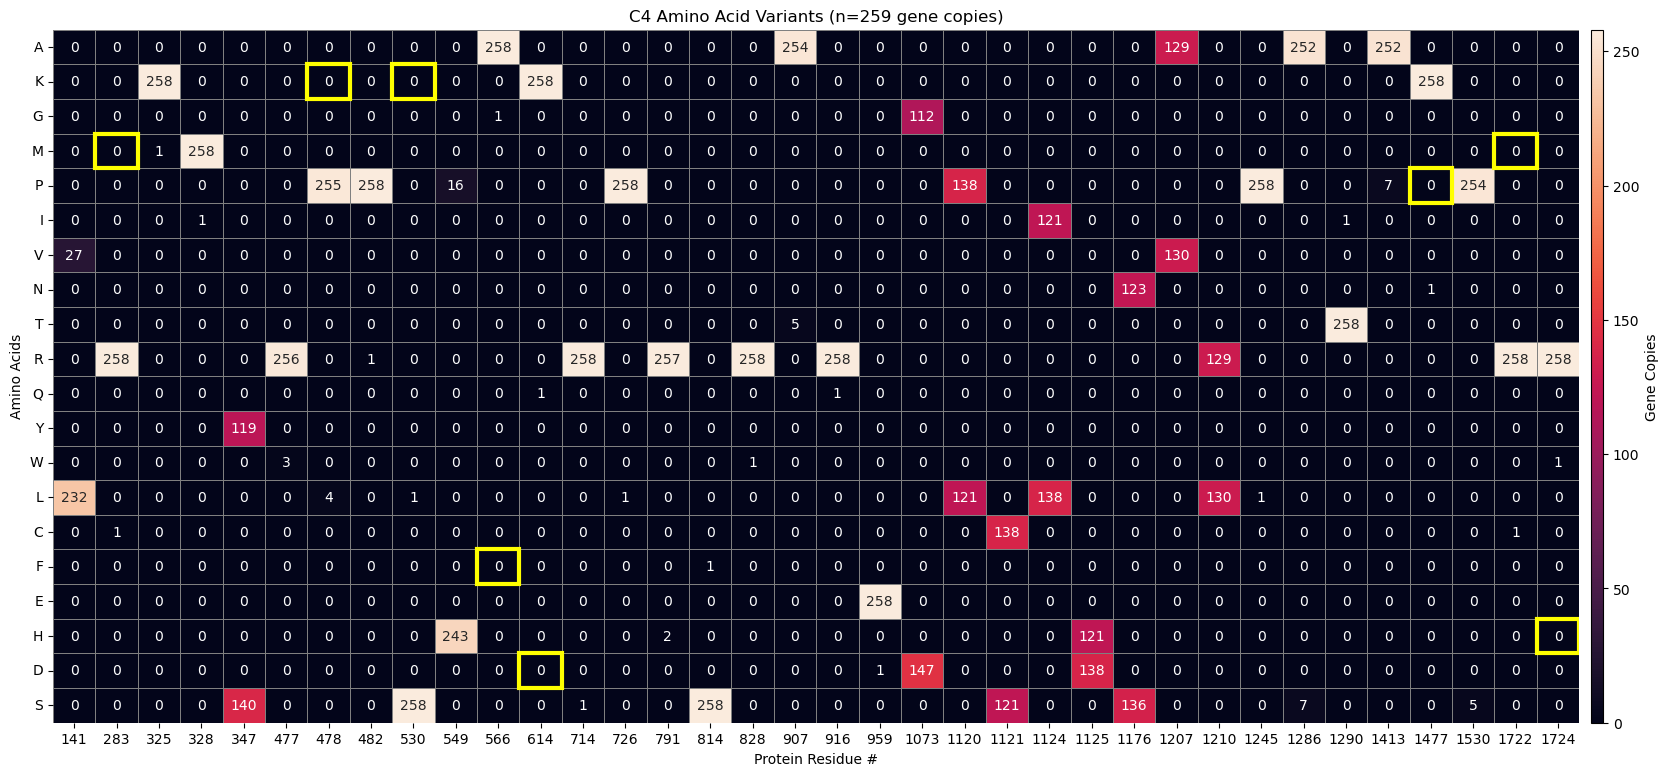

In [24]:
from matplotlib import rcParams
plt.rcParams.update(plt.rcParamsDefault)

fig, (ax, cax) = plt.subplots(nrows=1,ncols=2, figsize=(20,9),  gridspec_kw={"height_ratios":[1], 'width_ratios':[1,.008]})

sns.heatmap(aminoDF.loc[keepColumns].T, annot=True, ax=ax, linewidths=.5, fmt="d", linecolor='grey', cbar=False)

fig.colorbar(ax.get_children()[0], cax=cax, orientation="vertical")

for ticklabel, tickcolor in zip(ax.get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)

ax.tick_params(labelrotation=0)
ax.set_title("C4 Amino Acid Variants (n=259 gene copies)")
ax.set_ylabel("Amino Acids")
cax.set_ylabel("Gene Copies")

#plt.savefig('/home/mark/Desktop/HLA/C4/C4_AminoVariants.jpg', dpi=300, bbox_inches='tight')
ax.set_xlabel("Protein Residue #")
plt.subplots_adjust(wspace=0.015, hspace=0)
from matplotlib.patches import Rectangle

#283
ax.add_patch(Rectangle((1, 3), 1, 1, fill=False, edgecolor='yellow', lw=3))
#325
#ax.add_patch(Rectangle((2, 5), 1, 1, fill=False, edgecolor='yellow', lw=3))
#328
#ax.add_patch(Rectangle((3, 0), 1, 1, fill=False, edgecolor='yellow', lw=3))
#478
ax.add_patch(Rectangle((6, 1), 1, 1, fill=False, edgecolor='yellow', lw=3))
#530
ax.add_patch(Rectangle((8, 1), 1, 1, fill=False, edgecolor='yellow', lw=3))
#566
ax.add_patch(Rectangle((10, 15), 1, 1, fill=False, edgecolor='yellow', lw=3))
#614
ax.add_patch(Rectangle((11, 18), 1, 1, fill=False, edgecolor='yellow', lw=3))
#1477
ax.add_patch(Rectangle((32, 4), 1, 1, fill=False, edgecolor='yellow', lw=3))
#1722
ax.add_patch(Rectangle((34, 3), 1, 1, fill=False, edgecolor='yellow', lw=3))
#1724
ax.add_patch(Rectangle((35, 17), 1, 1, fill=False, edgecolor='yellow', lw=3))
#plt.savefig('/home/mark/Desktop/HLA/C4_Master/Figures/C4_AminoVariants.jpg', dpi=500, bbox_inches='tight')
#plt.savefig('/home/mark/Desktop/HLA/C4_Master/Figures/C4_AminoVariants.pdf', dpi=500, bbox_inches='tight')

plt.show()


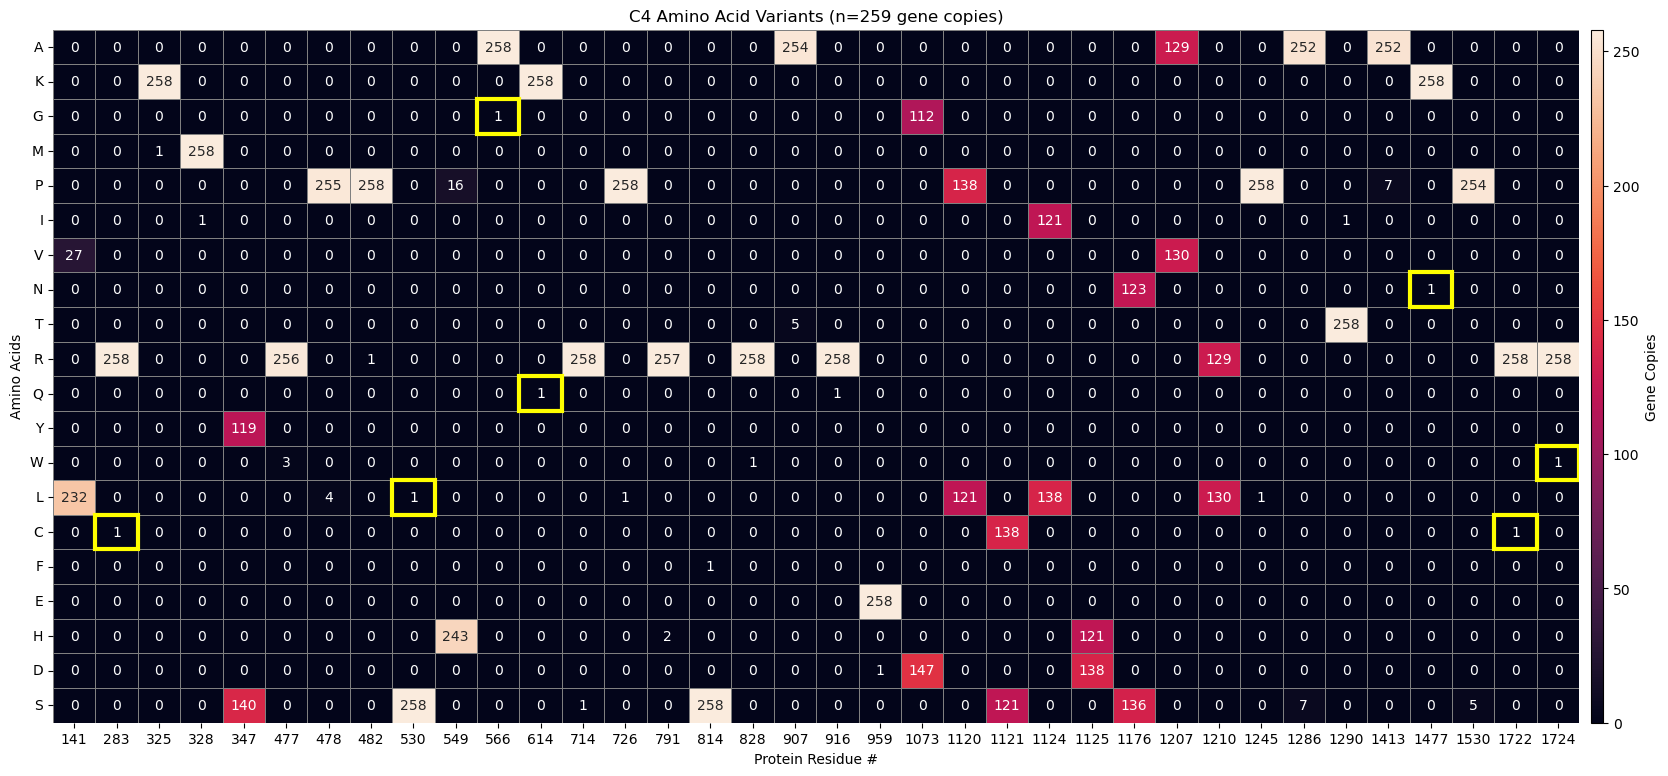

In [55]:
from matplotlib import rcParams
plt.rcParams.update(plt.rcParamsDefault)

fig, (ax, cax) = plt.subplots(nrows=1,ncols=2, figsize=(20,9),  gridspec_kw={"height_ratios":[1], 'width_ratios':[1,.008]})

sns.heatmap(aminoDF.loc[keepColumns].T, annot=True, ax=ax, linewidths=.5, fmt="d", linecolor='grey', cbar=False)

fig.colorbar(ax.get_children()[0], cax=cax, orientation="vertical")

for ticklabel, tickcolor in zip(ax.get_xticklabels(), colors):
    ticklabel.set_color(tickcolor)

ax.tick_params(labelrotation=0)
ax.set_title("C4 Amino Acid Variants (n=259 gene copies)")
ax.set_ylabel("Amino Acids")
cax.set_ylabel("Gene Copies")

#plt.savefig('/home/mark/Desktop/HLA/C4/C4_AminoVariants.jpg', dpi=300, bbox_inches='tight')
ax.set_xlabel("Protein Residue #")
plt.subplots_adjust(wspace=0.015, hspace=0)
from matplotlib.patches import Rectangle

#283
ax.add_patch(Rectangle((1, 14), 1, 1, fill=False, edgecolor='yellow', lw=3))
#325
#ax.add_patch(Rectangle((2, 5), 1, 1, fill=False, edgecolor='yellow', lw=3))
#328
#ax.add_patch(Rectangle((3, 0), 1, 1, fill=False, edgecolor='yellow', lw=3))
#478
#ax.add_patch(Rectangle((6, 11), 1, 1, fill=False, edgecolor='yellow', lw=3))
#530
ax.add_patch(Rectangle((8, 13), 1, 1, fill=False, edgecolor='yellow', lw=3))
#566
ax.add_patch(Rectangle((10, 2), 1, 1, fill=False, edgecolor='yellow', lw=3))
#614
ax.add_patch(Rectangle((11, 10), 1, 1, fill=False, edgecolor='yellow', lw=3))
#1477
ax.add_patch(Rectangle((32, 7), 1, 1, fill=False, edgecolor='yellow', lw=3))
#1722
ax.add_patch(Rectangle((34, 14), 1, 1, fill=False, edgecolor='yellow', lw=3))
#1724
ax.add_patch(Rectangle((35, 12), 1, 1, fill=False, edgecolor='yellow', lw=3))
#plt.savefig('/home/mark/Desktop/HLA/C4_Master/Figures/Manuscript/C4_AminoVariants.jpg', dpi=500, bbox_inches='tight')
#plt.savefig('/home/mark/Desktop/HLA/C4_Master/Figures/Manuscript/C4_AminoVariants.pdf', dpi=500, bbox_inches='tight')

plt.show()


## Known Variants

In [110]:
AllC4ResidueVariants

{5: {'C4A': [], 'C4B': ['WG', 'WX']},
 84: {'C4A': ['L', 'F'], 'C4B': ['L', 'F']},
 138: {'C4A': ['R', 'Q'], 'C4B': ['R', 'Q']},
 141: {'C4A': ['L', 'V'], 'C4B': ['L', 'V']},
 193: {'C4A': [], 'C4B': ['M', 'T']},
 211: {'C4A': ['G', 'E'], 'C4B': []},
 290: {'C4A': ['D', 'G'], 'C4B': []},
 347: {'C4A': ['Y', 'S', 'C', 'F'], 'C4B': ['S', 'Y']},
 360: {'C4A': ['W', '*'], 'C4B': []},
 477: {'C4A': ['W', 'R'], 'C4B': ['R', 'W']},
 482: {'C4A': ['P', 'R'], 'C4B': ['P', 'R']},
 527: {'C4A': ['T', 'A'], 'C4B': ['T', 'A']},
 549: {'C4A': ['H', 'P'], 'C4B': ['H', 'P']},
 608: {'C4A': [], 'C4B': ['L', 'V']},
 714: {'C4A': ['R', 'S'], 'C4B': ['R', 'S']},
 726: {'C4A': ['P', 'L'], 'C4B': []},
 729: {'C4A': ['R', 'Q'], 'C4B': []},
 752: {'C4A': [], 'C4B': ['A', 'V']},
 764: {'C4A': [], 'C4B': ['E', 'D']},
 775: {'C4A': [], 'C4B': ['R', 'C']},
 790: {'C4A': [], 'C4B': ['D', 'N']},
 791: {'C4A': ['R', 'H'], 'C4B': ['R', 'H']},
 794: {'C4A': [], 'C4B': ['I', 'T']},
 798: {'C4A': [], 'C4B': ['W', 'R']},

In [111]:
proteinVariantDF = aminoDF.loc[keepColumns].T.copy()

In [112]:
proteinVariantDF.head(2)

,141,283,325,328,347,477,478,482,530,549,...,1207,1210,1245,1286,1290,1413,1477,1530,1722,1724
I,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
E,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
ourC4Variants = {x:[] for x in proteinVariantDF.columns}
for row in proteinVariantDF.index:
    for column in proteinVariantDF.columns:
        
        if int(proteinVariantDF.at[row,column])==0:
            continue
        else:
            if row in list(referenceVariantsDictionary[column]):
                continue
            else:
                if column in AllC4ResidueVariants.keys():
                    if row in list(AllC4ResidueVariants[column]['C4A']):
                        continue
                    elif row in list(AllC4ResidueVariants[column]['C4B']):
                        continue
                    else:
                        ourC4Variants[column].append(row)
                else:
                    ourC4Variants[column].append(row)

In [114]:
myVariants = list(proteinVariantDF.columns)

In [115]:
myVariants

[141,
 283,
 325,
 328,
 347,
 477,
 478,
 482,
 530,
 549,
 566,
 614,
 714,
 726,
 791,
 814,
 828,
 907,
 916,
 959,
 1073,
 1120,
 1121,
 1124,
 1125,
 1176,
 1207,
 1210,
 1245,
 1286,
 1290,
 1413,
 1477,
 1530,
 1722,
 1724]

In [116]:
AllC4ResidueVariants[726]['C4A']

['P', 'L']

In [117]:
ourC4Variants

{141: [],
 283: ['C'],
 325: ['M'],
 328: ['I'],
 347: [],
 477: [],
 478: ['L'],
 482: [],
 530: ['L'],
 549: [],
 566: ['G'],
 614: ['Q'],
 714: [],
 726: [],
 791: [],
 814: [],
 828: [],
 907: [],
 916: [],
 959: [],
 1073: [],
 1120: [],
 1121: [],
 1124: [],
 1125: [],
 1176: [],
 1207: [],
 1210: [],
 1245: [],
 1286: [],
 1290: [],
 1413: ['P'],
 1477: ['N'],
 1530: ['S'],
 1722: ['C'],
 1724: ['W']}

In [118]:
pnorman=[52,57,82,134,141,347,426,477,482,488,495,549,600,680,714,726,729,805,825,895,907,937,963,986,1095,1119,1233,1245,1286,1413,1423,1495,1530,1688]

In [119]:
pNorman=[]
uniques=[]
for variant in ourC4Variants:
    if len(ourC4Variants[variant])>0:
        if int(variant) in pnorman:
            pNorman.append(f"{variant}-{ourC4Variants[variant]}: P.Norman")
        else:
            uniques.append(f"{variant}-{ourC4Variants[variant]}: Unique")

In [120]:
for x in pNorman:
    print(x)
print('\n')
for x in uniques:
    print(x)

1413-['P']: P.Norman
1530-['S']: P.Norman


283-['C']: Unique
325-['M']: Unique
328-['I']: Unique
478-['L']: Unique
530-['L']: Unique
566-['G']: Unique
614-['Q']: Unique
1477-['N']: Unique
1722-['C']: Unique
1724-['W']: Unique


In [ ]:
1413-['P']: P.Norman - CHECKED
1530-['S']: P.Norman - CHECKED 


283-['C']: Unique - NOT IN C4B, NOT IN C4A
325-['M']: Unique - NOT IN C4B, IN C4A (Not clear what the amino acid is)
328-['I']: Unique - NOT IN C4B, IN C4A (Not clear what the amino acid is)
478-['L']: Unique - NOT IN C4B, NOT IN C4A
530-['L']: Unique - NOT IN C4B, NOT IN C4A
566-['G']: Unique - NOT IN C4B, NOT IN C4A
614-['Q']: Unique - NOT IN C4B, NOT IN C4A
1477-['N']: Unique - NOT IN C4B, NOT IN C4A
1722-['C']: Unique - NOT IN C4B, NOT IN C4A
1724-['W']: Unique - NOT IN C4B, NOT IN C4A